# Import library

In [1]:
import numpy as np
import natsort
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

# Image_processing

In [2]:
class image_processing():
    def __init__(self, path1, path2, is_train):
        self.patch_size = 800

        self.rgb_img_path = path1
        self.patch_img_path = path2
        self.is_train = is_train
        self.crop_margin(self.rgb_img_path,is_train)
    
    def labeling(self,img):
        r = np.array([255, 0, 0])
        g = np.array([0, 255, 0])
        y = np.array([255, 255, 0])

        label_seg = np.zeros((img.shape[:2]), dtype=np.int)
        label_seg[(img==r).all(axis=2)] = 50
        label_seg[(img==g).all(axis=2)] = 30
        label_seg[(img==y).all(axis=2)] = 10
        label_seg = label_seg[:,:, np.newaxis]

        return label_seg

    def crop_margin(self,path,is_train):
        file_count = 0
        for file_path in path:
            file_count += 1
            img = cv2.imread(file_path)
            
            self.crop_rgb_img = img[:,25:-25,:]
            self. make_patch_img(self.crop_rgb_img, file_count, is_train)

        print(file_count,"장 전처리 완료.")


    def make_patch_img(self, img, file_count, is_train):
        if is_train:
            # img = cv2.GaussianBlur(img, (3,3),0)
            num_col_patch = img.shape[1] // self.patch_size    # 겹쳐지지 않은 열 패치 개수
            num_row_patch = img.shape[0] // self.patch_size    # 겹쳐지지 않은 행 패치 개수 

            over_col_patch = (self.patch_size * (num_col_patch + 1)) - img.shape[1] #겹쳐지는 가로 길이
            over_row_patch = (self.patch_size * (num_row_patch + 1)) - img.shape[0] #겹쳐지는 세로 길이

            file_count2 = 0
            for i in range(num_row_patch + 1):
                for j in range(num_col_patch + 1):
                    file_count2 += 1

                    if i == num_row_patch and j == num_col_patch:
                        patch_img = img[(self.patch_size * num_row_patch) - over_row_patch :, (self.patch_size * num_col_patch) - over_col_patch :, :]  
                        save_path = self.patch_img_path + f'/img{file_count}_{file_count2}.png'
                        cv2.imwrite(save_path, patch_img)  

                    elif j == num_col_patch:
                        patch_img = img[i*self.patch_size : i*self.patch_size + self.patch_size, (self.patch_size * num_col_patch) - over_col_patch :, :]  
                        save_path = self.patch_img_path + f'/img{file_count}_{file_count2}.png'
                        cv2.imwrite(save_path, patch_img)

                    elif i == num_row_patch:
                        patch_img = img[(self.patch_size * num_row_patch) - over_row_patch : , j*self.patch_size : j*self.patch_size+self.patch_size  , : ]
                        save_path = self.patch_img_path + f'/img{file_count}_{file_count2}.png'                   
                        cv2.imwrite(save_path, patch_img)

                    else:
                        patch_img = img[ i*self.patch_size : i*self.patch_size + self.patch_size,    j*self.patch_size :  j*self.patch_size+self.patch_size  ,:]
                        save_path = self.patch_img_path + f'/img{file_count}_{file_count2}.png'
                        cv2.imwrite(save_path, patch_img)    

        else :
            num_col_patch = img.shape[1] // self.patch_size    # 겹쳐지지 않은 열 패치 개수
            num_row_patch = img.shape[0] // self.patch_size    # 겹쳐지지 않은 행 패치 개수 

            over_col_patch = (self.patch_size * (num_col_patch + 1)) - img.shape[1] #겹쳐지는 가로 길이
            over_row_patch = (self.patch_size * (num_row_patch + 1)) - img.shape[0] #겹쳐지는 세로 길이
            
            img = self.labeling(img)
            
            file_count2 = 0
            for i in range(num_row_patch + 1):
                for j in range(num_col_patch + 1):
                    file_count2 += 1

                    if i == num_row_patch and j == num_col_patch:
                        patch_img = img[(self.patch_size * num_row_patch) - over_row_patch :, (self.patch_size * num_col_patch) - over_col_patch :, :]  
                        save_path = self.patch_img_path + f'/img{file_count}_{file_count2}.png'
                        cv2.imwrite(save_path, label_seg)

                    elif j == num_col_patch:
                        patch_img = img[i*self.patch_size : i*self.patch_size + self.patch_size, (self.patch_size * num_col_patch) - over_col_patch :, :]  
                        save_path = self.patch_img_path + f'/img{file_count}_{file_count2}.png'
                        cv2.imwrite(save_path, label_seg)

                    elif i == num_row_patch:
                        patch_img = img[(self.patch_size * num_row_patch) - over_row_patch : , j*self.patch_size : j*self.patch_size+self.patch_size  , : ]
                        save_path = self.patch_img_path + f'/img{file_count}_{file_count2}.png'     
                        cv2.imwrite(save_path, label_seg)

                    else:
                        patch_img = img[ i*self.patch_size : i*self.patch_size + self.patch_size,    j*self.patch_size :  j*self.patch_size+self.patch_size  ,:]
                        save_path = self.patch_img_path + f'/img{file_count}_{file_count2}.png'   
                        cv2.imwrite(save_path, label_seg)


---
# Main Code

In [3]:
# @@@@@@@@@@@@@@@@@@@ confirm 함수 리빌딩 필요 @@@@@@@@@@@@@@@@@@@@@@

# def confirm_patch(path, img_num):
#         file_list = os.listdir(path)
#         file_list = sortlist(file_list)
#         plt.figure(figsize =(12,12))
#         for i in range(25):
#             img_path = path + '/' + file_list[(img_num-1)*25 + i]
#             img = cv2.imread(img_path)
#             plt.subplot(5,5,i+1)
#             plt.imshow(img)
#         plt.show()

In [4]:
def sortlist(filelist):
    filelist = natsort.natsorted(filelist)
    return filelist

In [ ]:

train_dir_path = os.getenv("HOME")+ '/Cloud_data/cloud_train/'
validation_dir_path = os.getenv("HOME")+ '/Cloud_data/cloud_validation/'

train_file_path = os.path.join(train_dir_path,'train_clouds_data/png')
train_save_path = os.path.join(train_dir_path,'patch_img800')

train_label_file_path = os.path.join(train_dir_path,'train_clouds_labeling')
train_label_save_path = os.path.join(train_dir_path,'patch_labeling800')

validation_file_path = os.path.join(validation_dir_path,'validate_clouds_data/png')
validation_save_path = os.path.join(validation_dir_path,'patch_img800')

validation_label_file_path = os.path.join(validation_dir_path,'validate_clouds_labeling')
validation_label_save_path = os.path.join(validation_dir_path,'patch_labeling800')

In [ ]:
train_rgb_file_list = glob(os.path.join(train_file_path,"*RGB*png"))
train_label_file_list = glob(os.path.join(train_label_file_path,"*png"))

validation_rgb_file_list = glob(os.path.join(validation_file_path,"*RGB*png"))
validation_label_file_list = glob(os.path.join(validation_label_file_path,"*png"))

In [ ]:
train_rgb_file_list = sortlist(train_rgb_file_list)
train_label_file_list = sortlist(train_label_file_list)

validation_rgb_file_list = sortlist(validation_rgb_file_list)
validation_label_file_list = sortlist(validation_label_file_list)

In [ ]:
run_train_img = image_processing(train_rgb_file_list, train_save_path,is_train = True)
run_train_label = image_processing(train_label_file_list, train_label_save_path,is_train = False)

run_validation_img = image_processing(validation_rgb_file_list, validation_save_path,is_train=True)
run_validation_label = image_processing(validation_label_file_list, validation_label_save_path,is_train = False)

NameError: name 'image_processing' is not defined

In [ ]:
train_dir_path = os.getenv("HOME")+ '/Cloud_data/cloud_train/'
validation_dir_path = os.getenv("HOME")+ '/Cloud_data/cloud_validation/'

train_save_path = os.path.join(train_dir_path,'patch_img800')

train_label_save_path = os.path.join(train_dir_path,'patch_labeling800')

validation_save_path = os.path.join(validation_dir_path,'patch_img800')

validation_label_save_path = os.path.join(validation_dir_path,'patch_labeling800')

In [ ]:
train_rgb_file_list = glob(os.path.join(train_save_path,"*png"))
train_label_file_list = glob(os.path.join(train_label_save_path,"*png"))

validation_rgb_file_list = glob(os.path.join(validation_save_path,"*png"))
validation_label_file_list = glob(os.path.join(validation_label_save_path,"*png"))

In [ ]:
len(train_rgb_file_list)

7752

In [ ]:
len(train_label_file_list)

7752

In [ ]:
len(validation_rgb_file_list)

968

In [ ]:
len(validation_label_file_list)

968

---
# Confirm code

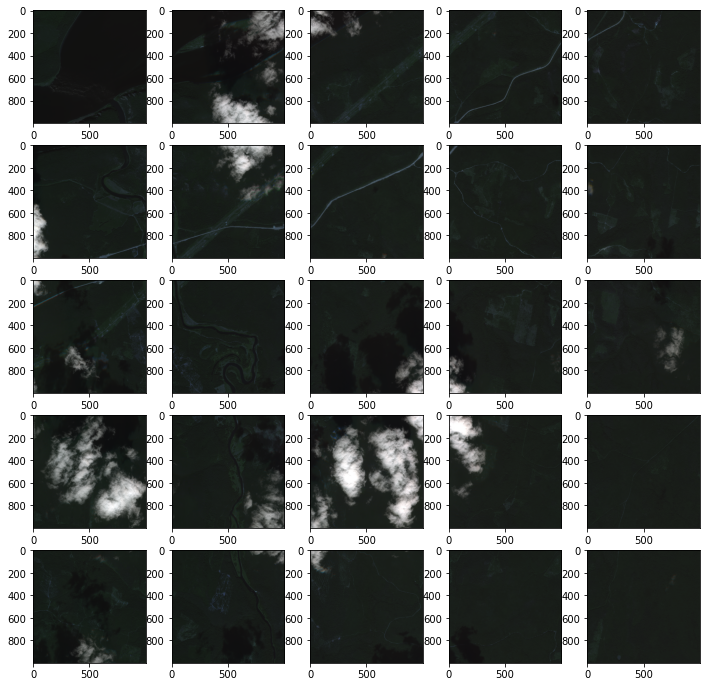

In [ ]:
# confirm_patch(train_save_path,1)

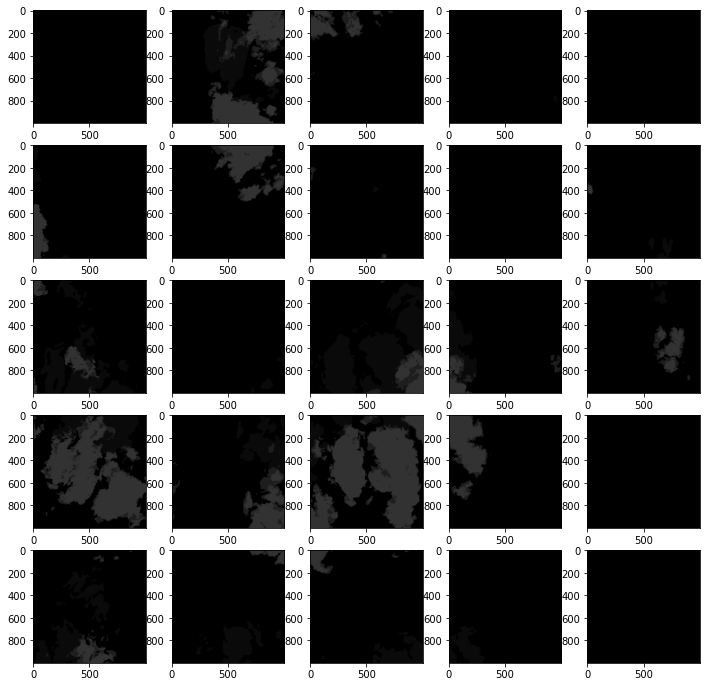

In [ ]:
# confirm_patch(train_label_save_path,1)

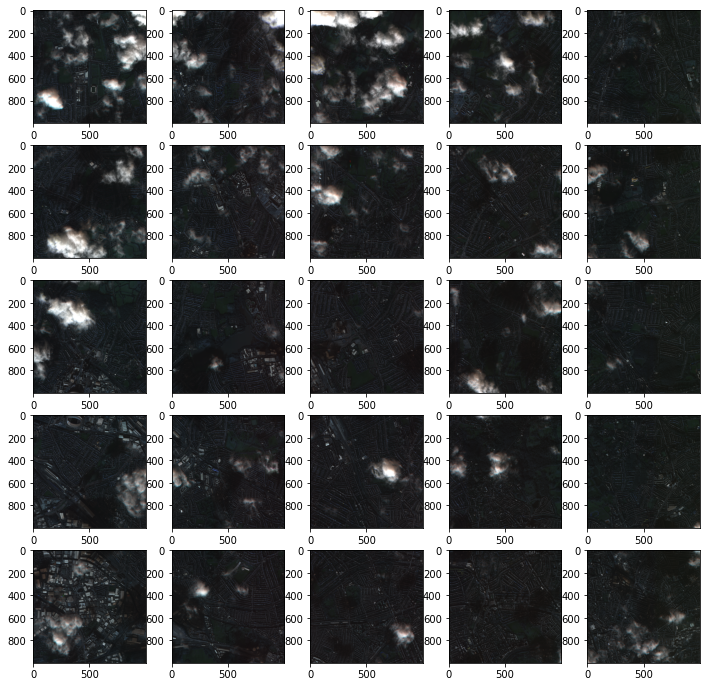

In [ ]:
# confirm_patch(validation_save_path,4)

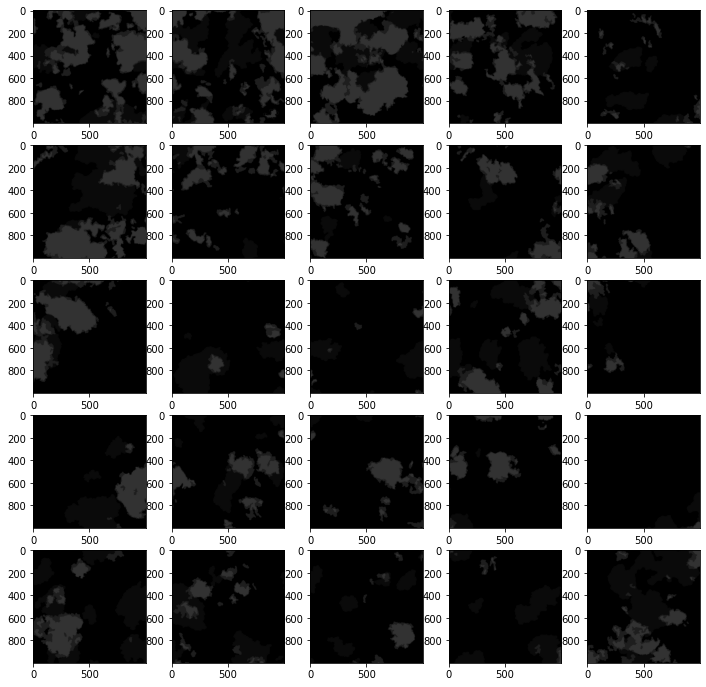

In [ ]:
# confirm_patch(validation_label_save_path,4)